# **Đề tài: Phân tích, thống kê video thịnh hành trên Youtube**


# 1. Thu thập dữ liệu

## 1.1 Đặt vấn đề
## **Trần Phan Minh Tiến**

    Question 1: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia:
    Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).

    Question 2: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.
## **Trần Minh Thuận**

    Question 3: Top 7 kênh YouTube có số lượng video thịnh hành nhiều nhất trên toàn cầu

    Question 4: Biểu đồ thể hiện thể loại nội dung trending cho từng quốc gia
## **Hoàng Văn Đức**

    Question 5: Vẽ biểu đồ cột thể hiện số lượng video thịnh hành theo giờ đăng trong ngày
    
    Question 6: Vẽ biểu đồ đường hoặc cột thể hiện lượt xem trung bình theo từng ngày trong tuần

## 1.2. Import libraries:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import kagglehub

## 1.3 TẢI DATA XUỐNG TỪ KAGGLEHUB

In [2]:
kaggle_download_path = kagglehub.dataset_download("datasnaek/youtube-new")
print("Path to dataset files:", kaggle_download_path)

Path to dataset files: /home/thuanc177/.cache/kagglehub/datasets/datasnaek/youtube-new/versions/115


# 2. Truy cập vào dữ liệu




## Đọc dữ liệu từ file

In [3]:
# Khởi tạo tạm thời dict dataframes để chứa các dataframe
dataframes = {}

In [4]:
# Định nghĩa các hàm để tiền xử lí dữ liệu
def read_and_fix_csv(path, fix_columns=None, default_encoding='utf-8', fallback_encoding='ISO-8859-1'):
    try:
        df = pd.read_csv(path, encoding=default_encoding)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding=fallback_encoding)

    if fix_columns:
        for col in fix_columns:
            if col in df.columns:
                df[col] = df[col].apply(fix_encoding)

    return df

# Sua lai encoding cho cac cot
def fix_encoding(s):
    try:
        return s.encode('latin1').decode('utf-8')
    except:
        return s  # giữ nguyên nếu không chuyển được

In [5]:
# Tạo dict lưu các DataFrame
country_codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
columns_to_fix = ['title', 'channel_title', 'description', 'tags']
for code in country_codes:
    filepath = f"{kaggle_download_path}/{code}videos.csv"
    dataframes[code] = read_and_fix_csv(filepath, fix_columns=columns_to_fix)

## 2.2. Xem thông tin của Dataset

### Đọc ngẫu nhiên 5 dòng dữ liệu của các data set 

In [6]:
dataframes['US'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [7]:
dataframes['CA'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...


In [8]:
dataframes['DE'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,LgVi6y5QIjM,17.14.11,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,inscope21,24,2017-11-13T17:08:49.000Z,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",252786,35885,230,1539,https://i.ytimg.com/vi/LgVi6y5QIjM/default.jpg,False,False,False,Heute gibt es mal wieder ein neues Format... w...
1,Bayt7uQith4,17.14.11,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,LUKE! Die Woche und ich,23,2017-11-12T22:30:01.000Z,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",797196,53576,302,1278,https://i.ytimg.com/vi/Bayt7uQith4/default.jpg,False,False,False,Kinder ferngesteuert! Kinder lassen sich sooo ...
2,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97190,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
3,AHtypnRk7JE,17.14.11,Das Fermi-Paradoxon,100SekundenPhysik,27,2017-11-12T15:00:01.000Z,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",380247,31821,458,1955,https://i.ytimg.com/vi/AHtypnRk7JE/default.jpg,False,False,False,►Alle Videos: http://bit.ly/1fa7Tw3\n\n\n✚Snap...
4,ZJ9We4bjcg0,17.14.11,18 SONGS mit Kelly MissesVlog (Sing-off),rezo,24,2017-11-12T13:10:36.000Z,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",822213,100684,2467,10244,https://i.ytimg.com/vi/ZJ9We4bjcg0/default.jpg,False,False,False,18 Song Mashup über den (veränderten) Beat von...


In [9]:
dataframes['FR'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Ro6eob0LrCY,17.14.11,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,24,2017-11-13T17:32:55.000Z,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|...",212702,29282,1108,3817,https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidé...
1,Yo84eqYwP98,17.14.11,"LA PIRE PARTIE ft Le Rire Jaune, Pierre Croce,...",Le Labo,24,2017-11-12T15:00:02.000Z,[none],432721,14053,576,1161,https://i.ytimg.com/vi/Yo84eqYwP98/default.jpg,False,False,False,Le jeu de société: https://goo.gl/hhG1Ta\n\nGa...
2,ceqntSXE-10,17.14.11,DESSINS ANIMÉS FRANÇAIS VS RUSSES 2 - Daniil...,Daniil le Russe,23,2017-11-13T17:00:38.000Z,"cartoon""|""pokémon""|""école""|""ours""|""мультфильм",482153,76203,477,9580,https://i.ytimg.com/vi/ceqntSXE-10/default.jpg,False,False,False,Une nouvelle dose de dessins animés français e...
3,WuTFI5qftCE,17.14.11,PAPY GRENIER - METAL GEAR SOLID,Joueur Du Grenier,20,2017-11-12T17:00:02.000Z,"Papy grenier""|""Metal Gear Solid""|""PS1""|""Tirage...",925222,85016,550,4303,https://i.ytimg.com/vi/WuTFI5qftCE/default.jpg,False,False,False,"Nouvel ,épisode de Papy Grenier ! Ce mois-ci o..."
4,ee6OFs8TdEg,17.14.11,QUI SAUTERA LE PLUS HAUT ? (VÉLO SKATE ROLLER ...,Aurelien Fontenoy,17,2017-11-13T16:30:03.000Z,"vélo""|""vtt""|""bmx""|""freestyle""|""bike""|""mtb""|""di...",141695,8091,72,481,https://i.ytimg.com/vi/ee6OFs8TdEg/default.jpg,False,False,False,Sauts à plus de 4 mètres de haut dans un tramp...


In [10]:
dataframes['GB'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13T02:30:38.000Z,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13T01:45:13.000Z,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...


In [11]:
dataframes['IN'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...
1,zUZ1z7FwLc8,17.14.11,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...",HJ NEWS,25,2017-11-13T05:43:56.000Z,"पीरियड्स के समय|""पेट पर पति करता ऐसा""|""देखकर द...",590101,735,904,0,https://i.ytimg.com/vi/zUZ1z7FwLc8/default.jpg,True,False,False,"पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं..."
2,10L1hZ9qa58,17.14.11,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,TFPC,24,2017-11-12T15:48:08.000Z,Stylish Star Allu Arjun @ ChaySam Wedding Rece...,473988,2011,243,149,https://i.ytimg.com/vi/10L1hZ9qa58/default.jpg,False,False,False,Watch Stylish Star Allu Arjun @ ChaySam Weddin...
3,N1vE8iiEg64,17.14.11,Eruma Saani | Tamil vs English,Eruma Saani,23,2017-11-12T07:08:48.000Z,"Eruma Saani|""Tamil Comedy Videos""|""Films""|""Mov...",1242680,70353,1624,2684,https://i.ytimg.com/vi/N1vE8iiEg64/default.jpg,False,False,False,This video showcases the difference between pe...
4,kJzGH0PVQHQ,17.14.11,why Samantha became EMOTIONAL @ Samantha naga ...,Filmylooks,24,2017-11-13T01:14:16.000Z,"Filmylooks|""latest news""|""telugu movies""|""telu...",464015,492,293,66,https://i.ytimg.com/vi/kJzGH0PVQHQ/default.jpg,False,False,False,why Samantha became EMOTIONAL @ Samantha naga ...


In [12]:
dataframes['JP'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,5ugKfHgsmYw,18.07.02,陸自ヘリ、垂直に落下＝路上の車が撮影,時事通信映像センター,25,2018-02-06T03:04:37.000Z,"事故|""佐賀""|""佐賀県""|""ヘリコプター""|""ヘリ""|""自衛隊""|""墜落""|""落下""|""現...",188085,591,189,0,https://i.ytimg.com/vi/5ugKfHgsmYw/default.jpg,True,False,False,佐賀県神埼市の民家に墜落した陸上自衛隊のＡＨ６４Ｄ戦闘ヘリコプターが垂直に落下する様子を、近...
1,ohObafdd34Y,18.07.02,イッテQ お祭り男宮川×手越 巨大ブランコ②,神谷えりな Kamiya Erina 2,1,2018-02-06T04:01:56.000Z,[none],90929,442,88,174,https://i.ytimg.com/vi/ohObafdd34Y/default.jpg,False,False,False,NaN
2,aBr2kKAHN6M,18.07.02,Live Views of Starman,SpaceX,28,2018-02-06T21:38:22.000Z,[none],6408303,165892,2331,3006,https://i.ytimg.com/vi/aBr2kKAHN6M/default.jpg,False,False,False,NaN
3,5wNnwChvmsQ,18.07.02,東京ディズニーリゾートの元キャストが暴露した秘密5選,アシタノワダイ,25,2018-02-06T06:08:49.000Z,アシタノワダイ,96255,1165,277,545,https://i.ytimg.com/vi/5wNnwChvmsQ/default.jpg,False,False,False,東京ディズニーリゾートの元キャストが暴露した秘密5選\n\nかたまりクリエイトさま\n【検証...
4,B7J47qFvdsk,18.07.02,榮倉奈々、衝撃の死んだふり！映画『家に帰ると妻が必ず死んだふりをしています。』特報,シネマトゥデイ,1,2018-02-06T02:30:00.000Z,[none],108408,1336,74,201,https://i.ytimg.com/vi/B7J47qFvdsk/default.jpg,False,False,False,家に帰ってきたサラリーマンのじゅん（安田顕）は、玄関で血を出して倒れている妻ちえ（榮倉奈々）...


In [13]:
dataframes['KR'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [14]:
dataframes['MX'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,SbOwzAl9ZfQ,17.14.11,Capítulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13T06:06:22.000Z,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,1836,https://i.ytimg.com/vi/SbOwzAl9ZfQ/default.jpg,False,False,False,Disfruta la presencia del Chef Torreblanca en ...
1,klOV6Xh-DnI,17.14.11,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13T05:11:58.000Z,La Voz Mexico 7,104972,271,174,369,https://i.ytimg.com/vi/klOV6Xh-DnI/default.jpg,False,False,False,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...
2,6L2ZF7Qzsbk,17.14.11,LOUIS CKAGÓ - EL PULSO DE LA REPÚBLICA,El Pulso De La República,25,2017-11-13T17:00:02.000Z,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,607,https://i.ytimg.com/vi/6L2ZF7Qzsbk/default.jpg,False,False,False,La canción del principio se llama “Este espíri...
3,hcY52MFWMDM,17.14.11,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13T03:47:10.000Z,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,208,https://i.ytimg.com/vi/hcY52MFWMDM/default.jpg,False,False,False,El video es de un Walmart en el pais centroame...
4,_OXDcGPVAa4,17.14.11,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13T19:17:48.000Z,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,7428,https://i.ytimg.com/vi/_OXDcGPVAa4/default.jpg,False,False,False,MI HERMANO NARRA MI RUTINA DE MAQUILLAJE\nhttp...


In [15]:
dataframes['RU'].head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,gDuslQ9avLc,17.14.11,Захар и Полина учатся экономить,Т—Ж БОГАЧ,22,2017-11-13T09:09:31.000Z,"захар и полина|""учимся экономить""|""копить день...",62408,334,190,50,https://i.ytimg.com/vi/gDuslQ9avLc/default.jpg,False,False,False,"Знакомьтесь, это Захар и Полина. Вместе с ними..."
1,AOCJIFEA_jE,17.14.11,Биржа Мемов #29. Большой выпуск,Druzhko Show,22,2017-11-13T17:32:11.000Z,"биржа мемов|""лев шагинян""|""мемы""|""пикчи""|""друж...",330043,43841,2244,2977,https://i.ytimg.com/vi/AOCJIFEA_jE/default.jpg,False,False,False,"В 29 выпуске Дружко Шоу Сергей сказал, что Бир..."
2,VAWNQDgwwOM,17.14.11,ХАЙП КЭМП - СВОЙ СРЕДИ ЧУЖИХ,Юлик,24,2017-11-13T16:11:31.000Z,"юмор|""комедия""|""влог""|""блог""|""смешно""|""смешное...",424596,49854,714,2944,https://i.ytimg.com/vi/VAWNQDgwwOM/default.jpg,False,False,False,http://kapitany.ru/!Yulik.cap - Факультет #Кап...
3,gknkFwKQfHg,17.14.11,Сочная кесадилья с курицей,Hochland,22,2017-11-13T06:51:10.000Z,"хохланд|""сыр""|""рецепты""|""как приготовить""|""вку...",112851,3566,122,80,https://i.ytimg.com/vi/gknkFwKQfHg/default.jpg,False,False,False,*** как готовить ресторанные блюда дома
4,3sYvZcwzZr8,17.14.11,КЛИПЫ РОДИТЕЛЕЙ НА ШКОЛЬНЫЙ ВЫПУСКНОЙ,Совергон,24,2017-11-13T16:52:36.000Z,"Совергон|""Sovergon""|""клипы""|""родители""|""школа""...",243469,36216,631,1692,https://i.ytimg.com/vi/3sYvZcwzZr8/default.jpg,False,False,False,❏ КОНКУРС КАПИТАНЫ: http://kapitany.ru/!Soverg...


# 3. Làm sạch dữ liệu

## 3.1. Các bước làm sạch dữ liệu chi tiết

Để đảm bảo chất lượng dữ liệu cho phân tích, chúng ta sẽ thực hiện các bước làm sạch sau cho DataFrame của mỗi quốc gia:

1.  **Kiểm tra tính đầy đủ (Completeness):**
    *   Mục tiêu: Đảm bảo các cột quan trọng không chứa giá trị thiếu (null).
    *   Các cột mục tiêu: `video_id`, `title` (tên video), `channel_title` (tên kênh), và `trending_date` (ngày trending).
    *   Hành động: Loại bỏ các hàng (dòng) có bất kỳ giá trị null nào trong các cột này.

2.  **Kiểm tra tính duy nhất (Uniqueness):**
    *   Mục tiêu: Đảm bảo mỗi video (`video_id`) là duy nhất trong bộ dữ liệu của mỗi quốc gia.
    *   Hành động: Loại bỏ các hàng có `video_id` trùng lặp, chỉ giữ lại bản ghi đầu tiên xuất hiện.

3.  **Kiểm tra tính nhất quán (Consistency):**
    *   Mục tiêu: Đảm bảo dữ liệu tuân theo định dạng và kiểu dữ liệu mong muốn.
    *   **Ngày tháng:** Kiểm tra cột `trending_date` có thống nhất theo định dạng `yy.dd.mm` (năm.ngày.tháng). Chuyển đổi sang kiểu dữ liệu datetime. Những hàng không đúng định dạng sẽ bị loại bỏ.
    *   **Kiểu dữ liệu số:** Kiểm tra các cột `views` (lượt xem), `likes` (lượt thích), `dislikes` (lượt không thích), `comment_count` (số bình luận) có phải là kiểu số nguyên. Những hàng có giá trị không phải số trong các cột này sẽ được loại bỏ, sau đó các cột này sẽ được chuyển đổi sang kiểu số nguyên.

In [16]:
# Remove rows with null values in essential columns
def clean_completeness(df, country_code):
    print(f"  Kiểm tra tính đầy đủ cho {country_code}:")
    initial_rows = len(df)
    essential_columns = ['video_id', 'title', 'channel_title', 'trending_date']
    
    df_cleaned = df.dropna(subset=essential_columns)
    rows_removed = initial_rows - len(df_cleaned)
    print(f"    - Loại bỏ {rows_removed} hàng thiếu giá trị, còn lại {len(df_cleaned)} hàng")
    return df_cleaned

# Fill missing values with defaults
def add_missing_values(df, country_code):
    print(f"  Thêm giá trị mặc định cho {country_code}:")
    
    missing_desc_count = df['description'].isna().sum()
    if missing_desc_count > 0:
        df['description'] = df['description'].fillna('No description')
        print(f"    - Thêm mô tả cho {missing_desc_count} hàng")

    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        missing_count = df[col].isna().sum()
        if missing_count > 0:
            df[col] = df[col].fillna(0)
            print(f"    - Thêm 0 cho {missing_count} hàng thiếu '{col}'")

    return df

# Remove duplicate video_ids, keep first occurrence
def clean_uniqueness(df, country_code):
    print(f"  Kiểm tra tính duy nhất cho {country_code}:")
    initial_rows = len(df)
    
    df_cleaned = df.drop_duplicates(subset=['video_id'], keep='first')
    rows_removed = initial_rows - len(df_cleaned)
    print(f"    - Loại bỏ {rows_removed} video trùng lặp, còn lại {len(df_cleaned)} hàng")
    return df_cleaned

# Convert data types and remove invalid format rows
def clean_consistency(df, country_code):
    print(f"  Kiểm tra tính nhất quán cho {country_code}:")
    initial_rows = len(df)
    df_cleaned = df.copy()

    # Xử lý trending_date: định dạng yy.dd.mm, mặc định UTC+0 nếu thiếu
    df_cleaned['trending_date'] = pd.to_datetime(
        df_cleaned['trending_date'],
        format='%y.%d.%m',
        errors='coerce',
        utc=True  # Converts to UTC-aware datetime
    )
    # Ensure trending_date is UTC. If series became naive (e.g. all NaT), localize. Else, convert.
    if df_cleaned['trending_date'].dtype.tz is None:
        df_cleaned['trending_date'] = df_cleaned['trending_date'].dt.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT')
    else:
        df_cleaned['trending_date'] = df_cleaned['trending_date'].dt.tz_convert('UTC')
    
    invalid_trending_date_count = df_cleaned['trending_date'].isnull().sum()
    df_cleaned.dropna(subset=['trending_date'], inplace=True)

    # Xử lý publish_time: có time zone, nếu thiếu mặc định UTC+0
    if 'publish_time' in df_cleaned.columns:
        df_cleaned['publish_time'] = pd.to_datetime(
            df_cleaned['publish_time'],
            errors='coerce',
            utc=True  # Converts to UTC-aware datetime
        )
        # Ensure publish_time is UTC. If series became naive, localize. Else, convert.
        if df_cleaned['publish_time'].dtype.tz is None:
            df_cleaned['publish_time'] = df_cleaned['publish_time'].dt.tz_localize('UTC', ambiguous='NaT', nonexistent='NaT')
        else:
            df_cleaned['publish_time'] = df_cleaned['publish_time'].dt.tz_convert('UTC')
            
        invalid_publish_time_count = df_cleaned['publish_time'].isnull().sum()
        df_cleaned.dropna(subset=['publish_time'], inplace=True)
    else:
        invalid_publish_time_count = 0

    # Convert numeric columns
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    total_invalid = invalid_trending_date_count + invalid_publish_time_count

    for col in numeric_cols:
        if col in df_cleaned.columns: # Ensure column exists
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
            invalid_count = df_cleaned[col].isnull().sum()
            total_invalid += invalid_count
            df_cleaned.dropna(subset=[col], inplace=True)
            if not df_cleaned.empty and col in df_cleaned.columns: # Check if df is not empty and col still exists
                if not df_cleaned[col].empty: # Ensure column is not empty before astype
                    df_cleaned[col] = df_cleaned[col].astype('Int64')

    print(f"    - Loại bỏ {total_invalid} hàng không hợp lệ, còn lại {len(df_cleaned)} hàng")
    return df_cleaned


In [17]:
def clean_all_dataframes(dataframes_dict, country_names_map):
    """
    Áp dụng tất cả các bước làm sạch cho mỗi DataFrame trong dictionary.
    Cập nhật dictionary `dataframes_dict` tại chỗ.
    """
    print("🚀 BẮT ĐẦU QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA 🚀")
    
    for country_code in list(dataframes_dict.keys()): # list() để tránh lỗi thay đổi dict khi lặp
        df = dataframes_dict[country_code]
        country_name = country_names_map.get(country_code, country_code)
        print(f"\n--- Đang xử lý: {country_name} ({country_code}) ---")
        initial_total_rows = len(df)
        print(f"  Số hàng ban đầu tổng cộng: {initial_total_rows}")

        if initial_total_rows == 0:
            print(f"    DataFrame cho {country_name} ({country_code}) rỗng. Bỏ qua làm sạch.")
            continue

        df_temp = clean_completeness(df.copy(), country_code) # .copy() để tránh SettingWithCopyWarning
        if not df_temp.empty:
            df_temp = clean_uniqueness(df_temp, country_code)
        if not df_temp.empty:
            df_temp = clean_consistency(df_temp, country_code)
        if not df_temp.empty:
            df_temp = add_missing_values(df_temp, country_code)
        
        dataframes_dict[country_code] = df_temp # Cập nhật trực tiếp dict gốc
        
        final_total_rows = len(df_temp)
        total_rows_removed_for_country = initial_total_rows - final_total_rows
        
        print(f"  --- Hoàn tất xử lý cho {country_name} ({country_code}) ---")
        print(f"    Số hàng ban đầu: {initial_total_rows}")
        print(f"    Số hàng còn lại sau khi làm sạch: {final_total_rows}")
        print(f"    Tổng số hàng đã loại bỏ: {total_rows_removed_for_country}")
        if initial_total_rows > 0:
            print(f"    Tỷ lệ dữ liệu còn lại: {final_total_rows / initial_total_rows * 100:.2f}%")
        else:
            print(f"    Tỷ lệ dữ liệu còn lại: N/A (không có dữ liệu ban đầu)")

    print("\n✅ HOÀN TẤT QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA ✅")


### Gọi hàm làm sạch dữ liệu

Bây giờ, chúng ta sẽ gọi hàm `clean_all_dataframes` để áp dụng các bước làm sạch đã định nghĩa ở trên cho tất cả các DataFrame của từng quốc gia. Biến `dataframes` (là một dictionary chứa các DataFrame) sẽ được cập nhật trực tiếp với các DataFrame đã được làm sạch.

In [18]:
country_names = {
    'US': 'United States',
    'CA': 'Canada',
    'DE': 'Germany',
    'FR': 'France',
    'GB': 'United Kingdom',
    'IN': 'India',
    'JP': 'Japan',
    'KR': 'South Korea',
    'MX': 'Mexico',
    'RU': 'Russia'
}

# Gọi hàm làm sạch dữ liệu
clean_all_dataframes(dataframes, country_names)

print("\nKiểm tra lại số lượng bản ghi sau khi làm sạch:")
total_records = 0
for code, df in dataframes.items():
    count = len(df)
    print(f"  - {country_names[code]} ({code}): {count:,} bản ghi")
    total_records += count
print(f"Tổng số bản ghi: {total_records:,}")


🚀 BẮT ĐẦU QUÁ TRÌNH LÀM SẠCH DỮ LIỆU CHO TẤT CẢ CÁC QUỐC GIA 🚀

--- Đang xử lý: United States (US) ---
  Số hàng ban đầu tổng cộng: 40949
  Kiểm tra tính đầy đủ cho US:
    - Loại bỏ 0 hàng thiếu giá trị, còn lại 40949 hàng
  Kiểm tra tính duy nhất cho US:
    - Loại bỏ 34598 video trùng lặp, còn lại 6351 hàng
  Kiểm tra tính nhất quán cho US:
    - Loại bỏ 0 hàng không hợp lệ, còn lại 6351 hàng
  Thêm giá trị mặc định cho US:
    - Thêm mô tả cho 102 hàng
  --- Hoàn tất xử lý cho United States (US) ---
    Số hàng ban đầu: 40949
    Số hàng còn lại sau khi làm sạch: 6351
    Tổng số hàng đã loại bỏ: 34598
    Tỷ lệ dữ liệu còn lại: 15.51%

--- Đang xử lý: Canada (CA) ---
  Số hàng ban đầu tổng cộng: 40881
  Kiểm tra tính đầy đủ cho CA:
    - Loại bỏ 0 hàng thiếu giá trị, còn lại 40881 hàng
  Kiểm tra tính duy nhất cho CA:
    - Loại bỏ 16454 video trùng lặp, còn lại 24427 hàng
  Kiểm tra tính nhất quán cho CA:
    - Loại bỏ 0 hàng không hợp lệ, còn lại 24427 hàng
  Thêm giá trị mặc đị

## 3.2. Làm giàu dữ liệu

### Thêm mã quốc gia trước khi merge data set

In [19]:
# Định nghĩa mapping tên quốc gia
country_names = {
    'US': 'United States',
    'CA': 'Canada', 
    'DE': 'Germany',
    'FR': 'France',
    'GB': 'United Kingdom',
    'IN': 'India',
    'JP': 'Japan',
    'KR': 'South Korea',
    'MX': 'Mexico',
    'RU': 'Russia'
}

def add_country_code_to_dataframes(dataframes_dict):
    """
    Thêm cột 'country_code' vào mỗi DataFrame trong dictionary trước khi merge.
    """
    print("🔧 THÊM CỘT COUNTRY_CODE VÀO CÁC DATAFRAMES")
    print("=" * 50)
    
    for country_code, df in dataframes_dict.items():
        # Thêm cột country_code
        df['country_code'] = country_code
        
        # Thêm cột country_name sử dụng mapping đã có
        df['country_name'] = country_names.get(country_code, country_code)
        
        print(f"✓ Đã thêm country_code '{country_code}' và country_name cho {len(df):,} bản ghi")
    
    print("\n✅ HOÀN TẤT THÊM CỘT COUNTRY_CODE CHO TẤT CẢ DATAFRAMES")
    return dataframes_dict

# Gọi hàm để thêm country_code vào các dataframes
dataframes = add_country_code_to_dataframes(dataframes)

🔧 THÊM CỘT COUNTRY_CODE VÀO CÁC DATAFRAMES
✓ Đã thêm country_code 'US' và country_name cho 6,351 bản ghi
✓ Đã thêm country_code 'CA' và country_name cho 24,427 bản ghi
✓ Đã thêm country_code 'DE' và country_name cho 29,627 bản ghi
✓ Đã thêm country_code 'FR' và country_name cho 30,581 bản ghi
✓ Đã thêm country_code 'GB' và country_name cho 3,272 bản ghi
✓ Đã thêm country_code 'IN' và country_name cho 16,307 bản ghi
✓ Đã thêm country_code 'JP' và country_name cho 12,912 bản ghi
✓ Đã thêm country_code 'KR' và country_name cho 15,876 bản ghi
✓ Đã thêm country_code 'MX' và country_name cho 33,513 bản ghi
✓ Đã thêm country_code 'RU' và country_name cho 34,282 bản ghi

✅ HOÀN TẤT THÊM CỘT COUNTRY_CODE CHO TẤT CẢ DATAFRAMES


### **TẠO DATASET TỔNG HỢP (MERGE)**

In [20]:
# Ignore index when concatenating to avoid index conflicts
combined_df = pd.concat(dataframes.values(), ignore_index=True)

In [21]:
combined_df.sample(20)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country_code,country_name
165871,aei3h_Oo3O0,2018-05-01 00:00:00+00:00,CAPÍTULO 23: ¿De qué hablaron Trump y López Ob...,El Privilegio de Mandar,23,2018-05-01 04:26:20+00:00,"Televisa|""El privilegio de mandar 2017""|""segun...",32861,954,136,107,https://i.ytimg.com/vi/aei3h_Oo3O0/default.jpg,False,False,False,¡Las Coreas qué! Te traemos en exclusiva el di...,MX,Mexico
23253,eVmxh5Uft0Y,2018-04-14 00:00:00+00:00,"Jason Derulo, Maluma - Colors",MalumaVEVO,10,2018-04-13 10:00:08+00:00,"Jason Derulo|""Maluma""|""Maluma Music""|""Maluma O...",3828884,237290,37198,23955,https://i.ytimg.com/vi/eVmxh5Uft0Y/default.jpg,False,False,False,"Jason Derulo, Maluma – “Colors”\n\nLISTEN TO ...",CA,Canada
176197,60IB-TFYl3s,2017-12-03 00:00:00+00:00,Вечерний Ургант. Острый репортаж с Аллой Михее...,Вечерний Ургант,24,2017-12-02 00:00:00+00:00,"Юмор|""Телевидение""|""Алла Михеева""|""шутка""|""смех""",141685,2736,172,152,https://i.ytimg.com/vi/60IB-TFYl3s/default.jpg,False,False,False,Алла Михеева представит свой новый Острый репо...,RU,Russia
199176,33mYSoUFoyc,2018-04-26 00:00:00+00:00,Сможет Жидкая Резина Защитить Желейного Медвед...,ЖЕЛЕЙНЫЙ МЕДВЕДЬ ЛАКИ,24,2018-04-25 09:35:08+00:00,"ЖЕЛЕЙНЫЙ МЕДВЕДЬ|""желейный мишка""|""желе""|""лаки...",21296,346,38,52,https://i.ytimg.com/vi/33mYSoUFoyc/default.jpg,False,False,False,Подписывайтесь на канал: https://goo.gl/uuQAqs...,RU,Russia
18235,R_KcDw87EIg,2018-02-26 00:00:00+00:00,NA LCS Spring (2018) | Week 6 Day 2,LoL Esports,20,2018-02-26 04:25:51+00:00,"League of Legends|""LoL""|""LCS""|""League Champion...",532539,2434,134,12,https://i.ytimg.com/vi/R_KcDw87EIg/default.jpg,False,False,False,NA LCS Spring Split Week 6 2018 #NALCS\n\nOpTi...,CA,Canada
164468,tC2USIqN2g4,2018-04-22 00:00:00+00:00,Doblando Rosa de Guadalupe *CiproShow*,CiproShow,23,2018-04-22 05:25:49+00:00,"México|""Mexico""|""Mexicanos""|""Telenovelas""|""Cip...",9957,1954,14,594,https://i.ytimg.com/vi/tC2USIqN2g4/default.jpg,False,False,False,Mi segunda entrega de La Rosa de Guadalupe a l...,MX,Mexico
113665,SkfRzb8V0Q0,2018-03-07 00:00:00+00:00,気に入らない…女子会に入れてもらえず事件をまき起こす猫！～悪あめちゃんへと豹変した姿が…Ca...,あめちゃん母ちゃん by Zf003971,15,2018-03-06 08:44:22+00:00,"Mew|""meow""|""Adorable""|""neko""|""paw""|""ねこ""|""ネコ""|""...",15999,291,9,27,https://i.ytimg.com/vi/SkfRzb8V0Q0/default.jpg,False,False,False,あめちゃんが話題の中心でないと…こうなる…ちなみに前代カメラもあめちゃんアタックを受けて壊れ...,JP,Japan
76402,xRCZ35W5rxw,2018-03-03 00:00:00+00:00,"Tellement Vrai, PERE ET MERE AVEUGLE NOUS AVON...",Reportage FR HD,24,2018-03-02 18:10:04+00:00,[none],2754,43,0,13,https://i.ytimg.com/vi/xRCZ35W5rxw/default.jpg,False,False,False,No description,FR,France
111291,FCU3H9UwYIM,2018-02-14 00:00:00+00:00,【海外の反応】米専門家が平昌五輪は巨額赤字と予想！→韓国「この情報は違う！黒字だと発表されて...,JAPAN! すごいぞ,25,2018-02-13 07:00:01+00:00,"UCSNtpfNXgOGw_WfRvBrydAw|""すごいぞJAPAN!""|""海外の反応""|...",26266,116,14,43,https://i.ytimg.com/vi/FCU3H9UwYIM/default.jpg,False,False,False,●チャンネル登録はこちらから！\nhttps://www.youtube.com/chann...,JP,Japan
51600,acPbUre-IgU,2018-04-14 00:00:00+00:00,Akhisar Bld 0-3 Beşiktaş Maç Özeti | 13.04.2018,Enes Tanır,17,2018-04-13 19:06:55+00:00,"maç özeti|""beşiktaş""|""akhisar""|""beşiktaş akhis...",399440,2137,366,588,https://i.ytimg.com/vi/acPbUre-IgU/default.jpg,False,False,False,Bu videomuzda Akhisar-Beşiktaş maçının özeti v...,DE,Germany


### Lưu data set đã xử lí

In [22]:
# Lưu dataset tổng hợp vào file CSV tại thư mục hiện tại
combined_df.to_csv('youtube_trending_combined_dataset.csv', index=False, encoding='utf-8')

print(f"📁 Tên file: youtube_trending_combined_dataset.csv")
print(f"📊 Số bản ghi: {len(combined_df):,}")
print(f"📋 Số cột: {len(combined_df.columns)}")
print(f"💾 Kích thước file ước tính: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

📁 Tên file: youtube_trending_combined_dataset.csv
📊 Số bản ghi: 207,148
📋 Số cột: 18
💾 Kích thước file ước tính: 493.92 MB
💾 Kích thước file ước tính: 493.92 MB


# **4. Trả lời các câu hỏi đặt ra cùng với visualizations**

##  **Trần Phan Minh Tiến**
### **Question 1**: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia: Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).


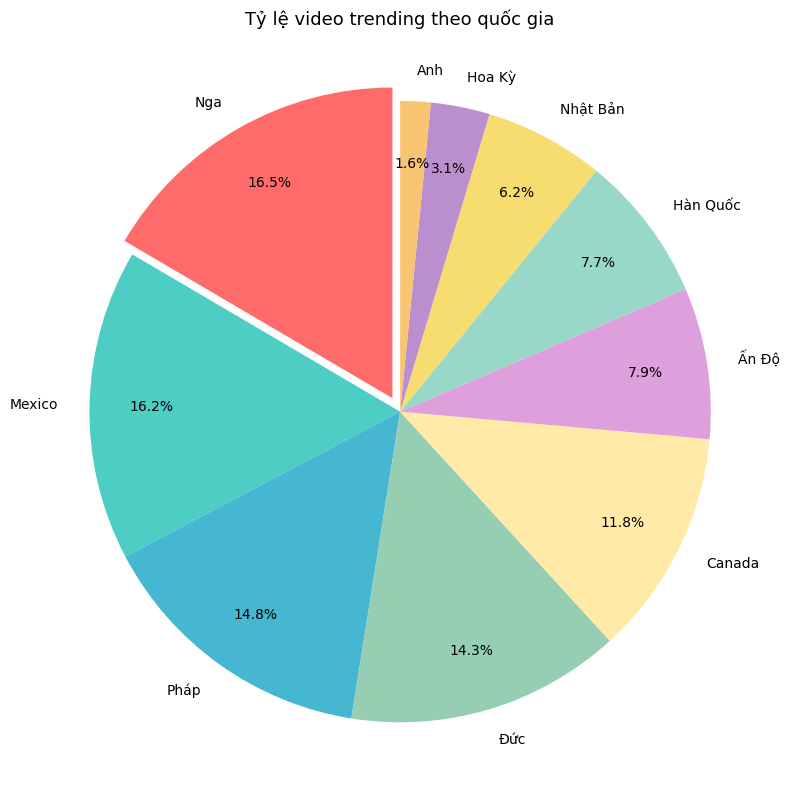

Tổng: 207,148 video

Nga: 34,282 video (16.5%)
Mexico: 33,513 video (16.2%)
Pháp: 30,581 video (14.8%)
Đức: 29,627 video (14.3%)
Canada: 24,427 video (11.8%)
Ấn Độ: 16,307 video (7.9%)
Hàn Quốc: 15,876 video (7.7%)
Nhật Bản: 12,912 video (6.2%)
Hoa Kỳ: 6,351 video (3.1%)
Anh: 3,272 video (1.6%)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
names = {
    'US': 'Hoa Kỳ', 'CA': 'Canada', 'DE': 'Đức', 'FR': 'Pháp',
    'GB': 'Anh', 'IN': 'Ấn Độ', 'JP': 'Nhật Bản',
    'KR': 'Hàn Quốc', 'MX': 'Mexico', 'RU': 'Nga'
}

# Lấy số lượng video mỗi nước
counts = {}
for c in codes:
    if c in dataframes:
        counts[c] = len(dataframes[c])

# Tổng tất cả video
s = sum(counts.values())

# Dữ liệu để vẽ
data = []
for c in sorted(counts, key=counts.get, reverse=True):
    data.append({
        'code': c,
        'name': names[c],
        'count': counts[c],
        'pct': counts[c] / s * 100
    })

# Đưa vào DataFrame
df = pd.DataFrame(data)

# Gán mã màu
cols = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7',
        '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#F8C471']

# Vẽ pie chart
plt.figure(figsize=(8, 8))
plt.pie(df['count'], 
        labels=df['name'],
        colors=cols[:len(df)],
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.8,
        explode=[0.05] + [0]* (len(df) - 1))
plt.title('Tỷ lệ video trending theo quốc gia', fontsize=13)
plt.axis('equal')
plt.tight_layout()
plt.show()

# In kết quả
print(f"Tổng: {s:,} video\n")
for row in df.itertuples():
    print(f"{row.name}: {row.count:,} video ({row.pct:.1f}%)")

## Nhận xét từ biểu đồ phân bố video trending theo quốc gia

### 1. Tổng thể xu hướng
Biểu đồ cho thấy **Nga** và **Mexico** dẫn đầu về số lượng video trending với tỷ lệ lần lượt là **16.5%** và **16.2%**. Điều này phản ánh hoạt động sôi nổi của cộng đồng người dùng và tính đa dạng của nội dung trên nền tảng YouTube tại các thị trường này.

---

### 2. Sự phân hóa rõ rệt theo quốc gia

**Nhóm dẫn đầu:**
- **Nga (16.5%)** và **Mexico (16.2%)** chiếm ưu thế tuyệt đối, có thể do:
    - Tăng trưởng mạnh trong sản xuất nội dung số
    - Cộng đồng người dùng tích cực tương tác
    - Thuật toán khuyến khích nội dung địa phương

**Sự tương phản bất ngờ:**
- **Hoa Kỳ** chỉ đạt **3.1%** và **Anh** **1.6%** - thấp đáng kể so với kỳ vọng
- Nguyên nhân có thể là:
    - Thuật toán phân bổ trending khác biệt theo khu vực
    - Sự cạnh tranh khốc liệt trong thị trường nội dung trưởng thành
    - Người dùng phân tán qua nhiều nền tảng khác

---

### 3. Phân tích theo vùng địa lý

**Châu Âu thống trị:**
- **Nga (16.5%)**, **Pháp (14.8%)**, **Đức (14.3%)** đều trong top 4
- Tổng cộng chiếm **45.6%** tổng số video trending
- Cho thấy sự phát triển mạnh mẽ của nền kinh tế số châu Âu

**Bắc Mỹ có sự phân cực:**
- **Canada (11.8%)** vs **Hoa Kỳ (3.1%)**
- Phản ánh sự khác biệt trong chính sách nội dung hoặc hành vi người dùng

**Châu Á đa dạng:**
- **Ấn Độ (7.9%)**, **Hàn Quốc (7.7%)**, **Nhật Bản (6.2%)**
- Mỗi quốc gia có đặc thù riêng về văn hóa nội dung số



## **Trần Phan Minh Tiến**
### **Question 2**: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.


[US]
Số video: 6,351
Lượt xem TB: 758,210
Lượt thích TB: 34,494
Lượt không thích TB: 1,427
Lượt bình luận TB: 4,502

[CA]
Số video: 24,427
Lượt xem TB: 486,052
Lượt thích TB: 18,398
Lượt không thích TB: 743
Lượt bình luận TB: 2,596

[DE]
Số video: 29,627
Lượt xem TB: 322,728
Lượt thích TB: 12,133
Lượt không thích TB: 667
Lượt bình luận TB: 1,653

[FR]
Số video: 30,581
Lượt xem TB: 238,752
Lượt thích TB: 9,348
Lượt không thích TB: 385
Lượt bình luận TB: 1,077

[GB]
Số video: 3,272
Lượt xem TB: 1,292,004
Lượt thích TB: 54,319
Lượt không thích TB: 2,347
Lượt bình luận TB: 6,377

[IN]
Số video: 16,307
Lượt xem TB: 397,775
Lượt thích TB: 10,480
Lượt không thích TB: 575
Lượt bình luận TB: 1,169

[JP]
Số video: 12,912
Lượt xem TB: 193,015
Lượt thích TB: 6,380
Lượt không thích TB: 250
Lượt bình luận TB: 884

[KR]
Số video: 15,876
Lượt xem TB: 243,674
Lượt thích TB: 7,552
Lượt không thích TB: 278
Lượt bình luận TB: 1,250

[MX]
Số video: 33,513
Lượt xem TB: 187,451
Lượt thích TB: 9,748
Lượt khô

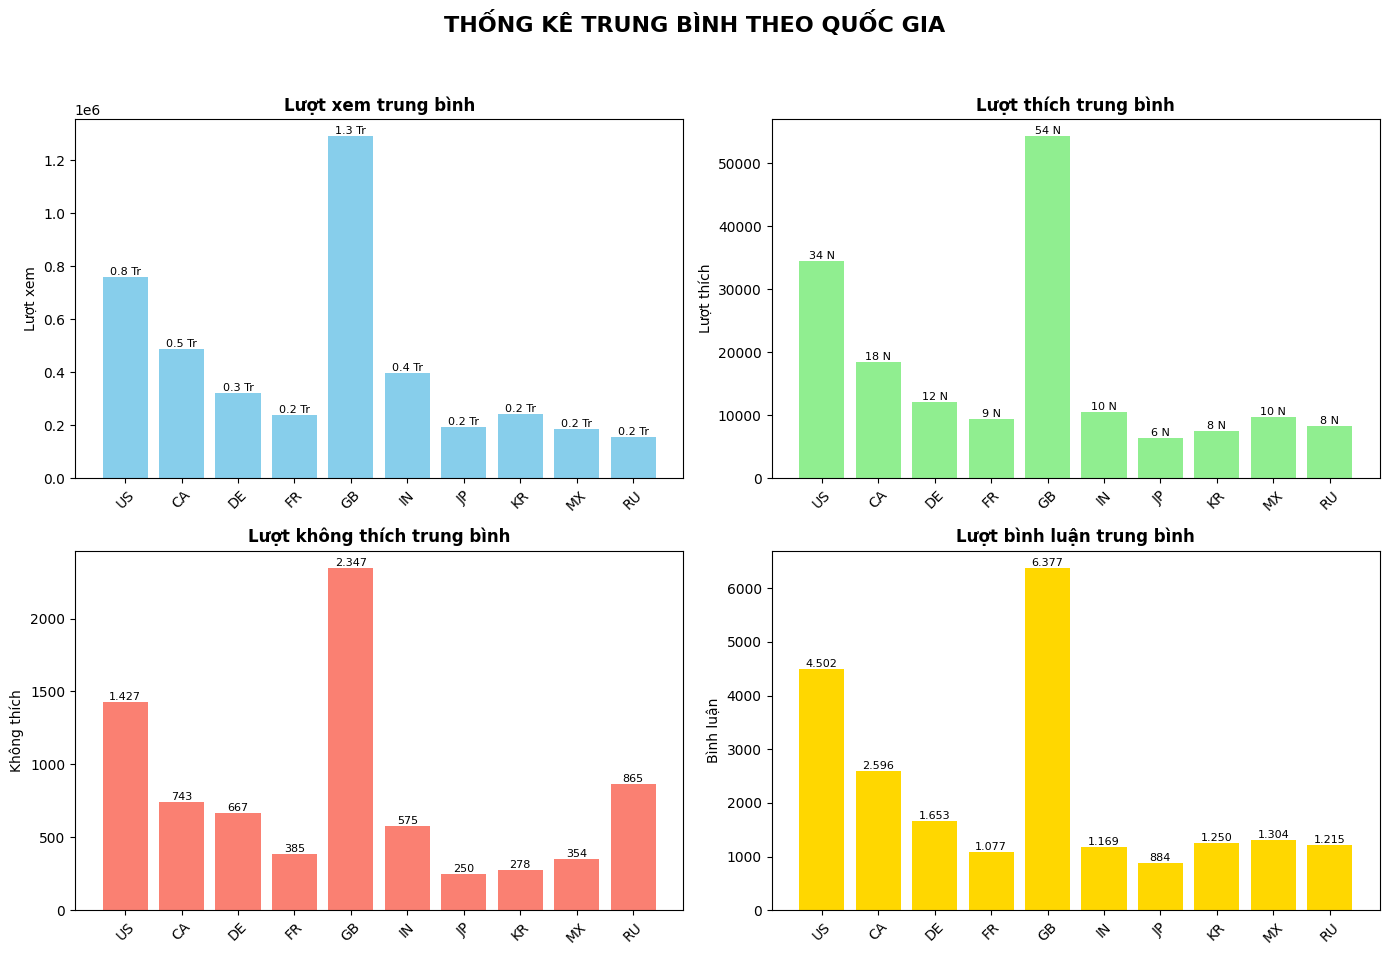

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_palette('husl')

# Quốc gia cần phân tích
countries = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']

# Tổng hợp dữ liệu
summary = []

for country in countries:
    df = dataframes[country]
    avg_views = df['views'].mean()
    avg_likes = df['likes'].mean()
    avg_dislikes = df['dislikes'].mean()
    avg_comments = df['comment_count'].mean()
    total_videos = len(df)

    print(f"\n[{country}]")
    print(f"Số video: {total_videos:,}")
    print(f"Lượt xem TB: {avg_views:,.0f}")
    print(f"Lượt thích TB: {avg_likes:,.0f}")
    print(f"Lượt không thích TB: {avg_dislikes:,.0f}")
    print(f"Lượt bình luận TB: {avg_comments:,.0f}")

    summary.append({
        'Quốc gia': country,
        'Lượt xem TB': avg_views,
        'Lượt thích TB': avg_likes,
        'Lượt không thích TB': avg_dislikes,
        'Lượt bình luận TB': avg_comments,
        'Số video': total_videos
    })

# Tạo DataFrame tổng hợp
df_summary = pd.DataFrame(summary)

# Hiển thị bảng số liệu
print("\n" + "="*50)
print("BẢNG SỐ LIỆU TRUNG BÌNH THEO QUỐC GIA")
print("="*50)
print(df_summary.round(2).to_string(index=False))

# Vẽ biểu đồ
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('THỐNG KÊ TRUNG BÌNH THEO QUỐC GIA', fontsize=16, fontweight='bold')

def draw(ax, col, color, title, ylabel, fmt=None):
    bars = ax.bar(df_summary['Quốc gia'], df_summary[col], color=color)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)
    for bar in bars:
        val = bar.get_height()
        label = fmt(val) if fmt else f'{val:,.0f}'.replace(',', '.')
        ax.text(bar.get_x() + bar.get_width()/2, val, label, ha='center', va='bottom', fontsize=8)

# Vẽ các biểu đồ với nhãn tiếng Việt
draw(axes[0, 0], 'Lượt xem TB', 'skyblue', 'Lượt xem trung bình', 'Lượt xem', lambda x: f'{x/1e6:.1f} Tr')
draw(axes[0, 1], 'Lượt thích TB', 'lightgreen', 'Lượt thích trung bình', 'Lượt thích', lambda x: f'{x/1e3:.0f} N')
draw(axes[1, 0], 'Lượt không thích TB', 'salmon', 'Lượt không thích trung bình', 'Không thích')
draw(axes[1, 1], 'Lượt bình luận TB', 'gold', 'Lượt bình luận trung bình', 'Bình luận')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Chừa chỗ cho tiêu đề
plt.show()

## **Trần Minh Thuận**

### **Question 3**: Top 7 kênh YouTube có số lượng video thịnh hành nhiều nhất trên toàn cầu

Phân tích để nhận diện những nhà sáng tạo/kênh có khả năng tạo ra nội dung trending một cách nhất quán và hiệu quả nhất.


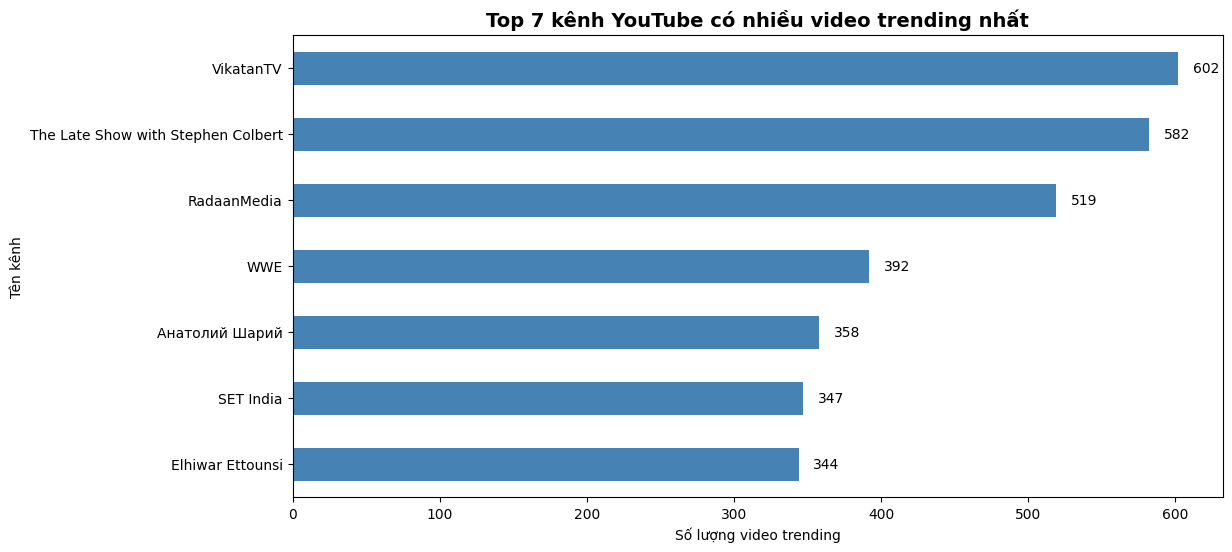

In [25]:
# Top 5 kênh có nhiều video trending nhất
top_channels = combined_df['channel_title'].value_counts().head(7)

plt.figure(figsize=(12, 6))
# [::-1] để đảo ngược thứ tự cột trong biểu đồ ngang
top_channels[::-1].plot(kind='barh', color='steelblue')

for i, v in enumerate(top_channels[::-1]):
    plt.text(v + 10, i, f'{v:,}', color='black', va='center', fontsize=10)

plt.title('Top 7 kênh YouTube có nhiều video trending nhất', fontsize=14, fontweight='bold')
plt.xlabel('Số lượng video trending')
plt.ylabel('Tên kênh')
plt.show()


### Nhận xét về Top 7 Kênh YouTube có nhiều video trending nhất:

**Phân bố dữ liệu:**

Danh sách top 7 kênh cho thấy sự đa dạng về nguồn gốc và loại nội dung:

1.  **VikatanTV** (Ấn Độ): Kênh tin tức và giải trí bằng tiếng Tamil.
2.  **The Late Show with Stephen Colbert** (Mỹ): Chương trình talkshow đêm khuya nổi tiếng.
3.  **RadaanMedia** (Ấn Độ): Công ty sản xuất nội dung giải trí Nam Ấn.
4.  **WWE** (Mỹ): Kênh thể thao giải trí đấu vật chuyên nghiệp.
5.  **Ahatornn Wapnn** (Thái Lan): Kênh giải trí hoặc tin tức tổng hợp.
6.  **SET India** (Ấn Độ): Kênh giải trí tổng hợp hàng đầu Ấn Độ.
7.  **Elhiwar Ettounsi** (Tunisia): Kênh truyền hình tư nhân nổi tiếng của Tunisia, bao gồm tin tức và giải trí.

*   **Ấn Độ thống trị:** Có đến 3 kênh trong top 7 (VikatanTV, RadaanMedia, SET India), cho thấy thị trường nội dung Ấn Độ rất sôi động và có khả năng tạo xu hướng cao.
*   **Mỹ vẫn có sức ảnh hưởng:** Với 2 kênh lớn là The Late Show và WWE, Mỹ cho thấy thế mạnh ở các chương trình talkshow và thể thao giải trí có lượng fan trung thành lớn.
*   **Sự hiện diện của các quốc gia khác:** Thái Lan và Tunisia cũng góp mặt, cho thấy nội dung địa phương hóa mạnh mẽ cũng có thể đạt được lượng video trending lớn.

**Nguyên do các kênh này có nhiều video trending:**

1.  **Nội dung chất lượng cao và nhất quán:**
    *   Các kênh này thường xuyên sản xuất nội dung được đầu tư kỹ lưỡng, từ kịch bản, quay phim đến hậu kỳ.
    *   Lịch đăng video đều đặn giúp giữ chân khán giả và tạo thói quen theo dõi.

2.  **Hiểu rõ đối tượng khán giả:**
    *   Họ tạo ra nội dung đánh trúng thị hiếu và mối quan tâm của lượng lớn khán giả mục tiêu.
    *   Ví dụ: VikatanTV và SET India phục vụ khán giả Ấn Độ với các chương trình giải trí, phim truyện, tin tức phù hợp văn hóa.

3.  **Tính thời sự và cập nhật:**
    *   Nhiều kênh (đặc biệt là tin tức và talkshow như The Late Show, Elhiwar Ettounsi, VikatanTV) nhanh chóng nắm bắt các sự kiện nóng, chủ đề đang được quan tâm để sản xuất video, thu hút lượng xem lớn trong thời gian ngắn.

4.  **Thương hiệu mạnh và cộng đồng lớn:**
    *   Các kênh như WWE, The Late Show đã có thương hiệu lâu năm và lượng người hâm mộ đông đảo trên toàn cầu. Video của họ dễ dàng được chia sẻ và lan truyền.
    *   SET India là một trong những kênh YouTube lớn nhất thế giới, có lợi thế về nguồn lực và khả năng quảng bá.

5.  **Tương tác cao:**
    *   Nội dung của họ thường kích thích sự tương tác (bình luận, thích, chia sẻ), đây là một yếu tố quan trọng để YouTube đánh giá và đưa video lên tab thịnh hành.

6.  **Đa dạng hóa nội dung (trong một số trường hợp):**
    *   Các kênh giải trí tổng hợp như SET India cung cấp nhiều loại chương trình khác nhau (phim, show truyền hình, âm nhạc), thu hút nhiều nhóm khán giả.

7.  **Tận dụng các sự kiện đặc biệt:**
    *   WWE thường có lượng video trending tăng vọt xung quanh các sự kiện lớn (pay-per-view). Các kênh tin tức cũng tương tự khi có các sự kiện quan trọng.

Nhìn chung, sự kết hợp giữa việc sản xuất nội dung chất lượng, đều đặn, phù hợp với thị hiếu khán giả, cùng với việc xây dựng thương hiệu mạnh và khả năng nắm bắt xu hướng là những yếu tố chính giúp các kênh này thống trị bảng xếp hạng video thịnh hành.


## **Trần Minh Thuận**

### **Question 4**: Vẽ biểu đồ thể hiện thể loại nội dung được ưa chuộng của từng quốc gia

Phân tích phân phối các thể loại video giữa các quốc gia để thấy rõ sự khác biệt trong xu hướng nội dung và sự tương đồng giữa các khu vực. Phân tích này sử dụng thông tin từ tiêu đề video để phân loại nội dung.


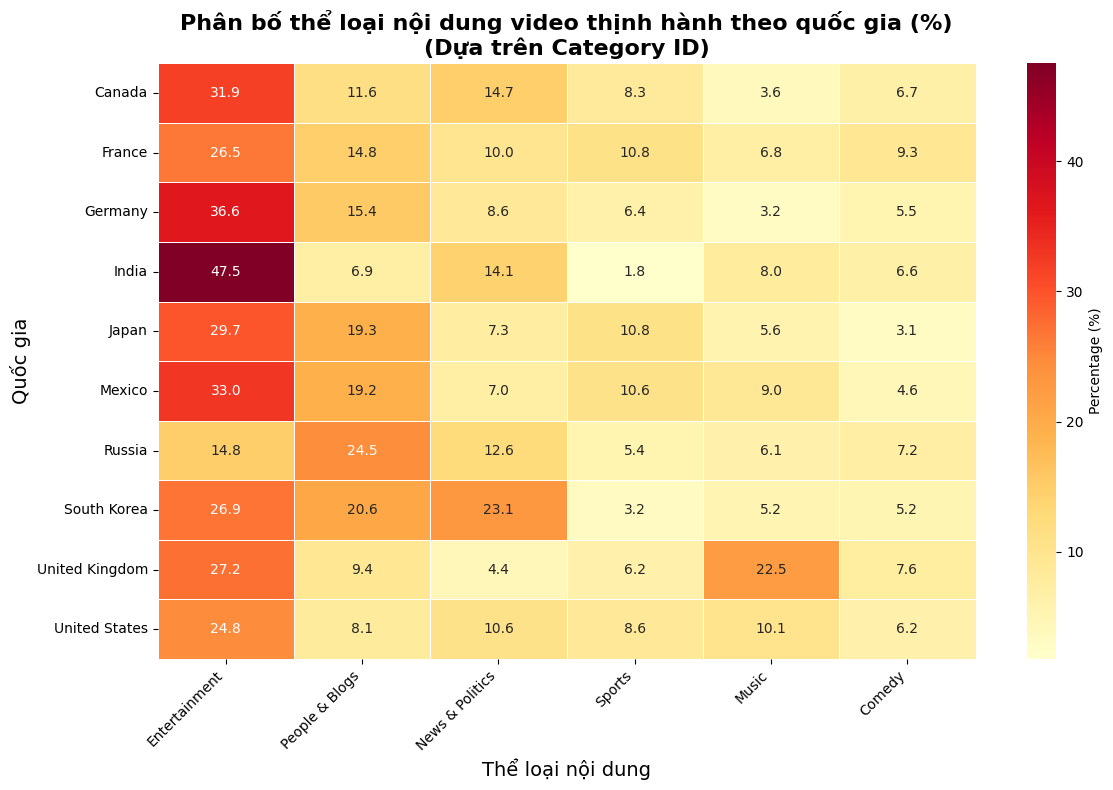

In [26]:
# Create a mapping of category_id to category names
# http://stackoverflow.com/questions/17698040/ddg#35877512
category_mapping = {
    1: 'Film & Animation',
    2: 'Autos & Vehicles', 
    10: 'Music',
    15: 'Pets & Animals',
    17: 'Sports',
    18: 'Short Movies',
    19: 'Travel & Events',
    20: 'Gaming',
    21: 'Videoblogging',
    22: 'People & Blogs',
    23: 'Comedy',
    24: 'Entertainment',
    25: 'News & Politics',
    26: 'Howto & Style',
    27: 'Education',
    28: 'Science & Technology',
    29: 'Nonprofits & Activism',
    30: 'Movies',
    31: 'Anime/Animation',
    32: 'Action/Adventure',
    33: 'Classics',
    34: 'Comedy',
    35: 'Documentary',
    36: 'Drama',
    37: 'Family',
    38: 'Foreign',
    39: 'Horror',
    40: 'Sci-Fi/Fantasy',
    41: 'Thriller',
    42: 'Shorts',
    43: 'Shows',
    44: 'Trailers'
}

# Add country name to combined_df for analysis
combined_df['country_code'] = ''
for country_code, df_country in dataframes.items():
    mask = combined_df['video_id'].isin(df_country['video_id'])
    combined_df.loc[mask, 'country_code'] = country_code

# Map country codes to country names
combined_df['country_name'] = combined_df['country_code'].map(country_names)

# Map category_id to category names
combined_df['category_name'] = combined_df['category_id'].map(category_mapping)

# Handle any unmapped categories
combined_df['category_name'] = combined_df['category_name'].fillna('Other')

# Create cross-tabulation of country vs category
content_by_country = pd.crosstab(combined_df['country_name'], combined_df['category_name'])

# Calculate percentage distribution for fair comparison between countries
content_pct = content_by_country.div(content_by_country.sum(axis=1), axis=0) * 100

# Select top categories to avoid overcrowding the heatmap
top_categories = content_by_country.sum().nlargest(6).index
content_pct_filtered = content_pct[top_categories]

# Create heatmap showing percentage distribution of content by country
plt.figure(figsize=(12, 8))
sns.heatmap(content_pct_filtered, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Percentage (%)'})
plt.title('Phân bố thể loại nội dung video thịnh hành theo quốc gia (%)\n(Dựa trên Category ID)', 
          fontsize=16, fontweight='bold')
plt.ylabel('Quốc gia', fontsize=14)
plt.xlabel('Thể loại nội dung', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Nhận xét từ biểu đồ heatmap phân bố nội dung:

Dựa trên phân tích 207,148 video từ 10 quốc gia với 18 thể loại khác nhau, ta có những phát hiện thú vị:

#### **1. Xu hướng toàn cầu**
- **Entertainment** là thể loại thống trị (29.2% tổng số video), phổ biến ở hầu hết các quốc gia
- **People & Blogs** đứng thứ 2 (17.1%), cho thấy xu hướng cá nhân hóa nội dung mạnh mẽ
- **News & Politics** chiếm 11.3%, phản ánh nhu cầu thông tin cao của người xem

#### **2. Đặc trưng riêng biệt theo vùng**

**Nhóm châu Á:**
- **Ấn Độ**: Nổi bật với Entertainment cao nhất (47.5%), cho thấy nhu cầu giải trí lớn, dân số lớn và thị phần giải trí cao cũng giải thích một phần cho lí do ấn độ thống lĩnh trong việc có các kênh sở hữu nhiều video trending ở câu hỏi số 3
- **Hàn Quốc**: Cân bằng giữa Entertainment (26.9%) và News & Politics (23.1%), phản ánh quan tâm chính trị cao
- **Nhật Bản**: Tập trung Entertainment (29.7%) và People & Blogs (19.3%)

**Nhóm châu Âu:**
- **Đức**: Dẫn đầu về Entertainment (36.6%) và People & Blogs (15.4%)
- **Pháp**: Cân bằng giữa Entertainment (26.5%), People & Blogs (14.8%) và Sports (10.8%)
- **Anh**: Đặc biệt với Music cao (22.5%), chỉ sau Entertainment (27.2%)

**Nhóm Bắc Mỹ:**
- **Canada**: Phân bố đều với Entertainment (31.9%) và quan tâm tin tức cao (14.7%)
- **Mỹ**: Cân bằng Entertainment (24.8%), News & Politics (10.6%) và Music (10.1%)

**Nhóm đặc biệt:**
- **Nga**: Duy nhất có People & Blogs dẫn đầu (24.5%), cho thấy văn hóa chia sẻ cá nhân mạnh
- **Mexico**: Entertainment cao (33.0%) với People & Blogs phát triển (19.2%)

#### **3. Insights chiến lược cho content creator**

**Thị trường toàn cầu**: Tập trung vào Entertainment và People & Blogs để có охват rộng nhất

**Thị trường từng khu vực**:
- **Châu Á**: Đầu tư vào Entertainment chất lượng cao
- **Châu Âu**: Kết hợp Entertainment với Sports và Music  
- **Bắc Mỹ**: Cân bằng giữa giải trí và thông tin
- **Nga**: Tận dụng xu hướng vlog/personal content mạnh mẽ

Sự đa dạng này phản ánh khác biệt văn hóa sâu sắc và mở ra cơ hội tối ưu nội dung theo từng thị trường cụ thể.

##### Hoàng Văn Đức

    Question 5: Vẽ biểu đồ cột thể hiện số lượng video thịnh hành theo giờ đăng trong ngày

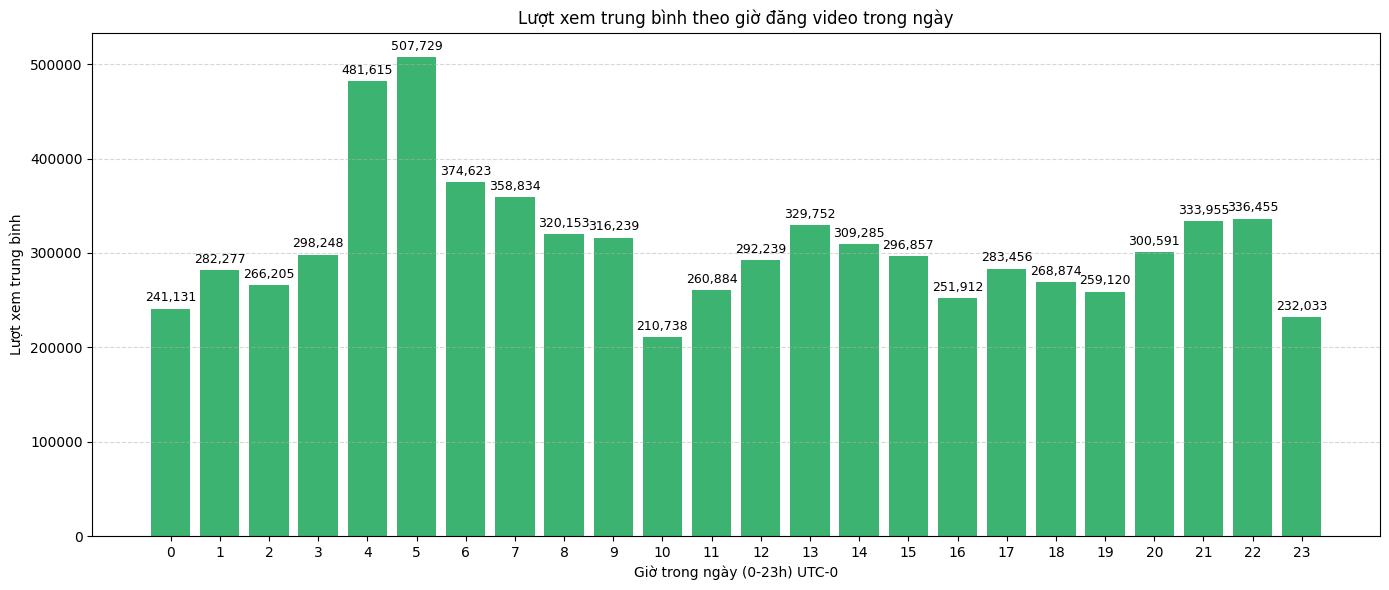

In [27]:
# Lọc bỏ các dòng thiếu dữ liệu cần thiết
df_analysis = combined_df.dropna(subset=['publish_time', 'views']).copy()

# Tạo cột giờ (hour) từ publish_time
## lieu cai nayy su dung theo gio hay gio bat dau phat ra de lay so lieu ca ngay
df_analysis['publish_hour'] = df_analysis['publish_time'].dt.hour

# Nhóm theo giờ và tính trung bình lượt xem
views_by_hour = df_analysis.groupby('publish_hour')['views'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
bars = plt.bar(views_by_hour['publish_hour'], views_by_hour['views'], color='mediumseagreen')

# Thêm số liệu cụ thể trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:,.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # dịch lên trên
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9)

# Giao diện biểu đồ
plt.xticks(range(0, 24))  # đảm bảo đủ 24 giờ
plt.title('Lượt xem trung bình theo giờ đăng video trong ngày')
plt.xlabel('Giờ trong ngày (0-23h) UTC-0')
plt.ylabel('Lượt xem trung bình')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Phân tích xu hướng đăng video theo giờ và hiệu suất

### 📊 Kết quả chính từ biểu đồ

**Lượt xem thấp nhất:** 10h sáng (~210k lượt xem)  
**Lượt xem cao nhất:** 5h sáng (~507k lượt xem)

---

### 🎯 Giải thích hiện tượng

#### **Tại sao 5h sáng lại hiệu quả nhất?**

YouTube phân phối video dựa trên **tín hiệu tương tác ban đầu** (đặc biệt là lượt xem và thời gian giữ chân). Vào 5h sáng:

- **Lượng người dùng rảnh cao:** Người dậy sớm, múi giờ khác nhau
- **Cạnh tranh thấp:** Ít kênh đăng video cùng thời điểm  
- **Phản hồi tích cực:** Người xem dễ tương tác → thuật toán đánh giá "có tiềm năng trending"

#### **Tại sao 10h sáng lại kém hiệu quả?**

- **Người dùng bận rộn:** Giờ đi học, đi làm
- **Cạnh tranh khốc liệt:** Phải cạnh tranh với nhiều video đăng sau đó
- **Tương tác thấp:** Ít người nhấn xem → thuật toán đánh giá "không trending"

---

### 💡 Insights quan trọng

> **YouTube cần tín hiệu tốt trong 30 phút - 2 giờ đầu sau khi đăng**

Nhiều creator tưởng "giờ hành chính" sẽ tốt hơn, nhưng thực tế thuật toán cần **phản hồi ngay lập tức** để quyết định phân phối.

---

### 🚀 Gợi ý tối ưu cho Content Creator

#### **1. Chọn khung giờ vàng**
- **5h-6h sáng:** Tối ưu nhất cho tích lũy tín hiệu
- **20h-22h:** Thời gian phụ tốt (không quá sớm, không quá muộn)

#### **2. Chiến lược dài hạn**
- **Duy trì lịch đăng:** Giúp người xem quen với thời gian
- **Thumbnail + tiêu đề hấp dẫn:** Tối đa hóa CTR ngay từ đầu
- **Tạo thói quen:** Người xem biết khi nào có video mới

#### **3. Tận dụng thuật toán**
- **30 phút đầu quyết định:** Tập trung promotion trong khung giờ này